In [22]:
import statsmodels.api as sm
import pandas as pd
import pygsheets
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import date, timedelta



In [23]:
DATA_URL = "https://raw.githubusercontent.com/mikelor/TsaThroughput/main/data/processed/tsa/throughput/TsaThroughput.AUS.csv"


In [42]:
df = pd.read_csv(DATA_URL)
df = df.pivot_table(index="Date",aggfunc="sum")

df["Passengers"] = df['AUS AUS01']+ df['AUS AUS02']+df['AUS AUS02E']+df['AUS AUS02W']+ df['AUS AUS03']

df.index = pd.DatetimeIndex(df.index)
all_days = pd.date_range(df.index.min(), df.index.max(), freq='D')
df = df.reindex(all_days)
y = df[['Passengers']]
y['Passengers'] = y['Passengers'].fillna(0)

mod = sm.tsa.statespace.SARIMAX(y,order=(2,1,2),seasonal_order=(0,1,2,7),enforce_stationarity=True,enforce_invertibility=False)
results = mod.fit(disp=0)

fcast = results.get_forecast(steps=30).summary_frame()

output = fcast[['mean']]
output = output.rename(columns={'mean':'Passengers'})
output['pred'] = True
y_out = y
y_out['pred'] = False
output = y_out.append(output)
output["Date"] = output.index

/var/folders/pg/cslfpj_n0qq43f2kmc968klw0000gn/T/ipykernel_32591/3297687623.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/pg/cslfpj_n0qq43f2kmc968klw0000gn/T/ipykernel_32591/3297687623.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
today_cast = fcast.loc[date.strftime(date.today(),format="%Y-%m-%d")]

today_val = today_cast['mean']

y = y[y.index > date.strftime(date.today()-timedelta(90),format="%Y-%m-%d")]

y = y[y["Passengers"]>0]

lowest = y["Passengers"].median()-(2*y["Passengers"].std())
highest = y["Passengers"].median()+(2*y["Passengers"].std())

v_low =  y["Passengers"].median()-(1*y["Passengers"].std())
v_high =  y["Passengers"].median()+(1*y["Passengers"].std())

low =  y["Passengers"].median()-(.5*y["Passengers"].std())
high =  y["Passengers"].median()+(.5*y["Passengers"].std())

if today_val <=  v_low:
    title_text = "Very low traffic expected today"
    tweet = "Austin's traffic is expected to be very low today."

elif today_val <=  low:
    title_text = "Relatively low traffic expected today"
    tweet = "Austin's traffic is expected to be relatively low today."

elif (today_val >  low and today_val <= high):
    title_text = "Relatively normal traffic expected today"
    tweet = "Austin's traffic is expected to be normal today."

elif today_val > high:
    title_text = "Relatively busy traffic expected today"
    tweet = "Austin's traffic is expected to be relatively busy today."

elif today_val > high:
    title_text = "Very busy traffic expected today"
    tweet = "Austin's traffic is expected to be very busy today."

fig = go.Figure(go.Indicator(
    mode = "gauge",
    value = today_val,
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': title_text},
    gauge={
        'axis': {'range':[lowest,highest],'visible': True},
        'bar': {'color': "black"},
        'steps': [
            {'range':[lowest,v_low], 'color':'#1a9641'},
            {'range':[v_low,low], 'color':'#a6d96a'},
            {'range':[low,high], 'color':'#ffffbf'},
            {'range':[high,v_high], 'color':'#fdae61'},
            {'range':[v_high,highest], 'color':'#d7191c'},
        ],
}))

fig.show()
#fig.write_image("traffic_plot.png")

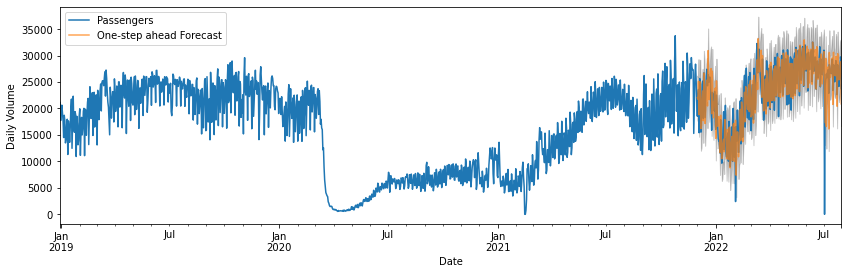

In [9]:
# One-step ahead chart
pred = results.get_prediction(start=pd.to_datetime('2021-12-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Volume')
plt.legend()
plt.show()